# Bands

This is a notebook that focuses on some additional documentation for the band structures. First, we setup all necessary stuff without providing much context.

In [1]:
import numpy as np
import scipy as sp

# To have access to tsc module
import sys
import os

# Get the grandparent directory of the current working directory
gparent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# Append the parent directory to the PYTHONPATH
sys.path.append(gparent_dir)

# ---------------------------------------------------------------------------------

import config

from tsc.utilities import get_RPTS, get_nndists, get_connections, fermi
from tsc.basis_atoms import single_atom, extract_atom_vectors
from tsc.hamiltonian import hopping_elements, get_exponentials
from tsc.hamiltonian import prep_N_hamiltonian, get_N_hamiltonian, prep_SC_hamiltonian, get_SC_hamiltonian

from tsc.bands import get_points_dict, get_sym_points, get_band_KPTS, get_weights

from plotting import plot_bands, plot_bands_weighted

# Get config variables
globals().update({k: v for k, v in vars(config.Config).items() if not k.startswith("__")})

# Construct the lattice sites matrix
RPTS = get_RPTS(a_1, a_2, a_3, NCELLS)

In [36]:
# ------------- Change these to get new results -----------------------------------

# Call functions from basis_atoms.py to get atom
atoms1 = single_atom(x = 0.0, y = 0.0, z = 0.0, atom_type = 1, E_0 = -0.3, U = 0.0, 
                     n_bar = 1.0, B_x = -1.0, B_y = 1.0, B_z = 0.0, Λ = 1.2)
atoms2 = single_atom(x = 0.5, y = 0.5, z = 0.5, atom_type = 2, E_0 = 0.5, U = 0.0, 
                     n_bar = 1.0, B_x = 0.0, B_y = 0.0, B_z = 1.2, Λ = 1.0)

atoms = np.vstack([atoms1,atoms2])

# ---------------------------------------------------------------------------------

# Extract the vectors from the called function
TPTS, atom_types, E_0, U, n_bar, B, Λ = extract_atom_vectors(atoms)

# Write down the number of basis atoms
N_b: int = TPTS.shape[0]

num_neighbs = get_nndists(RPTS, TPTS, R_max)

# Get the maximum number of neighbours
max_neighb = num_neighbs.max()

# Get the atom_IJ and Rvec_ij matrices
atom_IJ, Rvec_ij = get_connections(max_neighb, RPTS, TPTS, R_max)

# Get the number of different atom types based on the basis_atoms configuration
# Also re-encode the atom_types as 0, 1, 2, etc.
unique_atoms, atom_types = np.unique(atom_types, return_inverse=True)
N_unique: int = unique_atoms.shape[0]

# Construct a completely symmetrical case
t_0 = np.ones((N_unique, N_unique))

# Get the hopping elements
t = hopping_elements(atom_IJ, num_neighbs, Rvec_ij, atom_types, t_0, R_0)

We will not perform all self-consistency loops here, we will simply go with a one-shot run, directly on the k-points relevant to the band structure, simply to showcase how our functions and plots work.

In [37]:
# Setup hand-picked values
μ = 0.0
n = np.ones((N_b))
Δ = np.ones((N_b), dtype=np.complex128)

In [38]:
# Insert the required direction across symmetry points
points_str = "Γ-Χ-Μ-Γ-R-X"
# Setup k-mesh, either as list or as int
k_mesh = [100,100,100,100,100]

# Extract letters as list
letters = points_str.split("-")
# Get the vectors for the high symmetry points
sym_points = get_sym_points(letters, latt, ALAT)
# Extract the corresponding k-points
band_KPTS, x_for_plot, k_mesh = get_band_KPTS(sym_points, k_mesh)

# Call the get_exponentials() function once again, to get the new Fourier exponentials
band_fourier = get_exponentials(Rvec_ij, band_KPTS)

## Eigenvalues only plot

In [39]:
# Create placeholder array for the eigenvalues.
band_N_k = band_KPTS.shape[0]
band_vals = np.zeros((band_N_k,4*N_b))

# prepare the Hamiltonian using the converged values for μ and n
H_prep = prep_SC_hamiltonian(E_0, μ, U, n, n_bar, B, Δ, s_0, s_1, s_2, s_3)
    
for k in range(band_N_k):
    
    H_copied = np.copy(H_prep)
    H = get_SC_hamiltonian(k, H_copied, atom_IJ, num_neighbs, band_fourier, t)

    # Solve the eigenvalue problem only
    w = sp.linalg.eigh(H, eigvals_only=True)
    band_vals[k,:] = w

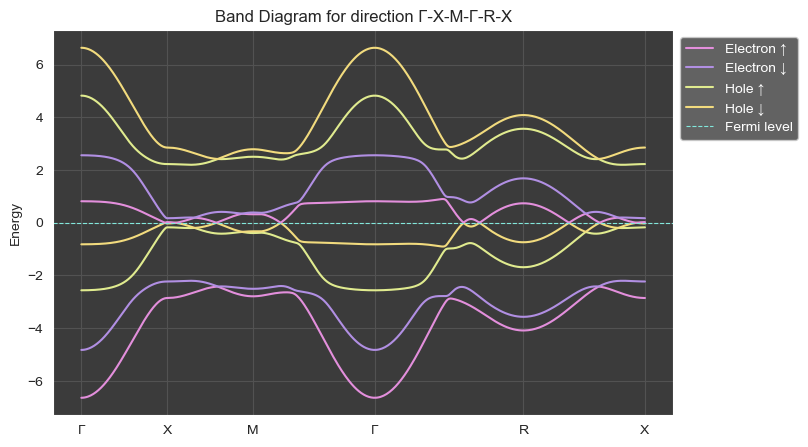

In [40]:
# With the eigenvalues at hand, we may proceed with plotting
cum_k = np.hstack((np.array([0], dtype=int),k_mesh.cumsum()))
plot_points_x = x_for_plot[cum_k]

plot_bands(band_vals, x_for_plot, plot_points_x, letters, μ, points_str)

## Weighted plot

In [9]:
band_vals = np.zeros((band_N_k,4*N_b))
band_vecs = np.zeros((band_N_k,4*N_b,4*N_b), dtype=np.complex128)

# prepare the Hamiltonian using the converged values for n and Δ
H_prep = prep_SC_hamiltonian(E_0, μ, U, n, n_bar, B, Δ, s_0, s_1, s_2, s_3)
    
for k in range(band_N_k):
    
    H_copied = np.copy(H_prep)
    H = get_SC_hamiltonian(k, H_copied, atom_IJ, num_neighbs, band_fourier, t)

    # Solve the full problem
    w, v = sp.linalg.eigh(H)
    
    band_vals[k,:] = w
    band_vecs[k,:,:] = v

# Get the weights using the wavefunctions
weights = get_weights(N_b, band_N_k, band_vecs)

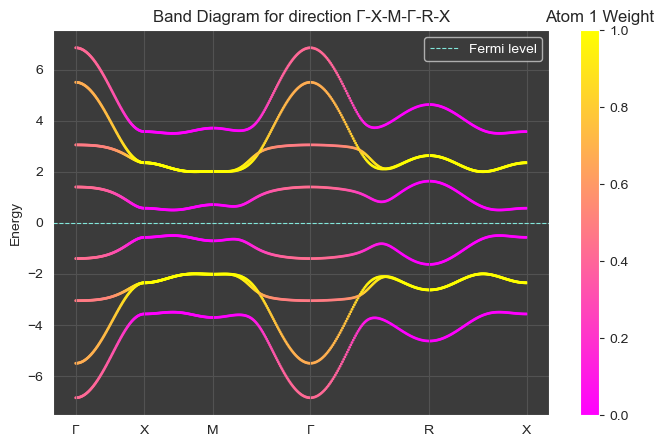

In [10]:
# Plot for first atom
plot_bands_weighted(0, weights, band_vals, x_for_plot, plot_points_x, letters, μ, points_str)

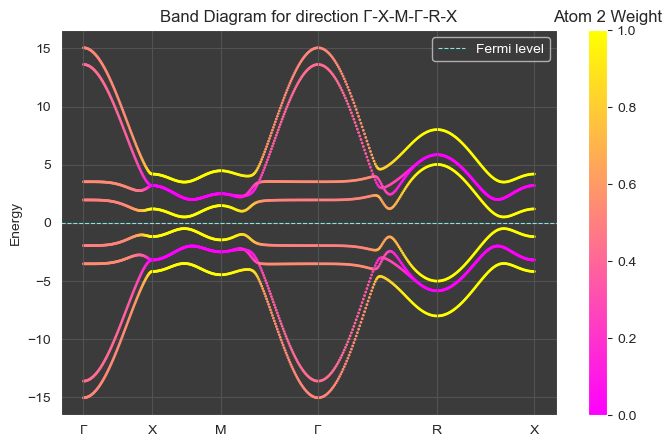

In [9]:
# Plot for second atom
plot_bands_weighted(1, weights, band_vals, x_for_plot, plot_points_x, letters, μ, points_str)